Goals
Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

chatbot-messaging will be the langsmith project

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot-messaging"

Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to explore:\n\n1. **Dolphins**: Known for their intelligence and playful nature, dolphins are part of the cetacean family and are closely related to whales.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are another member of the cetacean family.\n\n3. **Seals**: These are pinnipeds, which means "fin-footed" mammals. They are adapted to life both in water and on land.\n\n4. **Sea Lions**: Also pinnipeds, sea lions are known for their external ear flaps and ability to "walk" on land using their large flippers.\n\n5. **Walruses**: Distinguished by their long tusks and whiskers, walruses are social animals often found in Arctic regions.\n\n6. **Manatees**: Often referred to as "sea cows," manatees are gentle giants that graze on underwater vegetation in warm coastal waters and rivers.\n\n7. **Dugongs**: Similar to manatees, dugongs are marine he

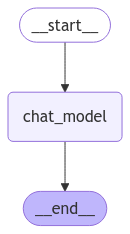

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are social animals often seen in pods. There are various species, including the bottlenose dolphin and the orca, which is technically a dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are less acrobatic and have different teeth and facial structures.

3. **Seals**: These pinnipeds are divided into earless seals (true seals) and eared seals, which include sea lions and fur seals. They are adept 

# chat messaging tool 

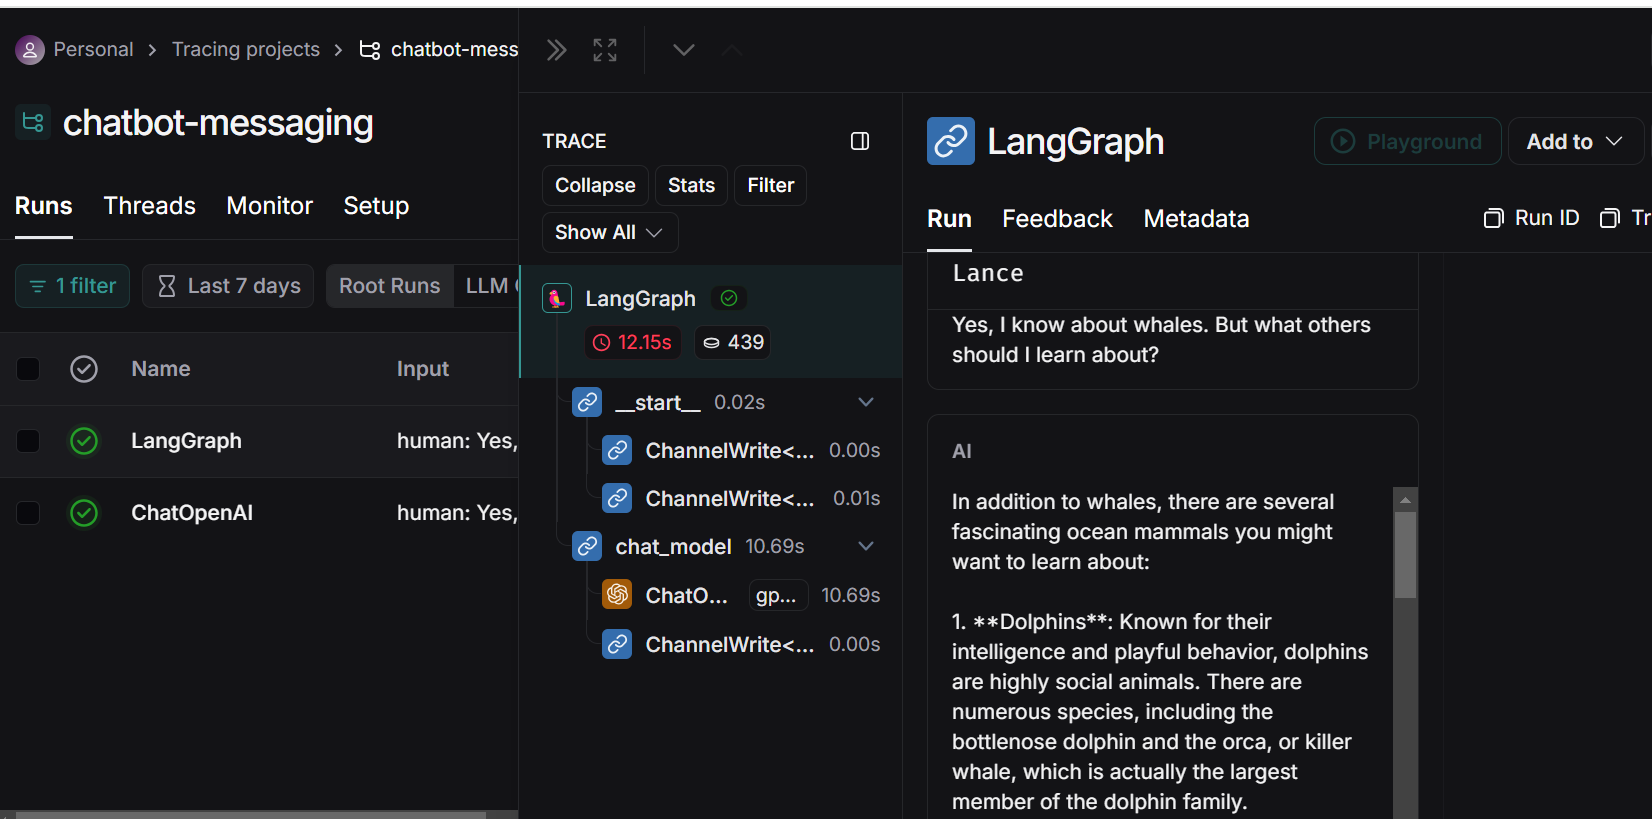

# reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using RemoveMessage and the add_messages reducer.

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

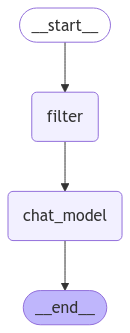

In [8]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))
messages.append(HumanMessage("Also , can you let me now  what is the best oceonagraph book to study about mammals?", name="Lance", id="5"))


In [11]:
# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Also , can you let me now  what is the best oceonagraph book to study about mammals?
================================== Ai Message ==================================

If you're interested in learning about marine life beyond whales, there are several fascinating groups of ocean animals you might want to explore:

1. **Dolphins and Porpoises**: Closely related to whales, these intelligent and social creatures are known for their playful behavior and complex communication.

2. **Seals, Sea Lions, and Walruses**: These pinnipeds are adept swimmers and are found in a variety of marine environments.

3. **Manatees and Dugongs**: Often called "sea cows," these gentle herbivores inhabit warm coastal waters and rivers.

4. **Sea Otters**: Known f

# from the above message , it is clear , that only last 2 conversations are maintained 

In [12]:
## again invoke  for a set of messages 
### result : we can see  only last 2 messages  maintained

# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))
messages.append(HumanMessage("Also , can you let me now  what is the best oceonagraph book to study about mammals?", name="Lance", id="5"))
messages.append(HumanMessage("Also , What is the capital of India?", name="Lance", id="6"))
messages.append(HumanMessage("Also , What is the capital of bangladesh?", name="Lance", id="7"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()


================================ Human Message =================================
Name: Lance

Also , What is the capital of India?
================================ Human Message =================================
Name: Lance

Also , What is the capital of bangladesh?
================================== Ai Message ==================================

The capital of Bangladesh is Dhaka.


# Another way to  avoid changing or overwriting  graph state ,  we can just filter out the messages that we pass to our chat model
For example, just pass in a filtered list: llm.invoke(messages[-1:]) to the model

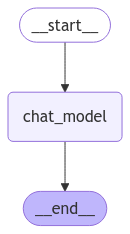

In [13]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 HumanMessage(content='Also , can you let me now  what is the best oceonagraph book to study about mammals?', additional_kwargs={}, response_metadata={}, name='Lance', id='5'),
 HumanMessage(content='Also , What is the capital of India?', additional_kwargs={}, response_metadata={}, name='Lance', id='6'),
 HumanMessage(content='Also , What is the capital of bangladesh?', additional_kwargs={}, response_metadata={}, name='Lance', id='7')]

In [15]:
#Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [17]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Also , can you let me now  what is the best oceonagraph book to study about mammals?
================================ Human Message =================================
Name: Lance

Also , What is the capital of India?
================================ Human Message =================================
Name: Lance

Also , What is the capital of bangladesh?
================================== Ai Message ================

In [19]:
# so in the above messages list , we can see the entire messages list  
## however ,  when we  see in lanagmisth , we  will see only the alst message showing up 
## lets invoke our graph

In [20]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Also , can you let me now  what is the best oceonagraph book to study about mammals?
================================ Human Message =================================
Name: Lance

Also , What is the capital of India?
================================ Human Message =================================
Name: Lance

Also , What is the capital of bangladesh?
================================== Ai Message ================

In [21]:
# Invoke again, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Also , can you let me now  what is the best oceonagraph book to study about mammals?
================================ Human Message =================================
Name: Lance

Also , What is the capital of India?
================================ Human Message =================================
Name: Lance

Also , What is the capital of bangladesh?
================================== Ai Message ================

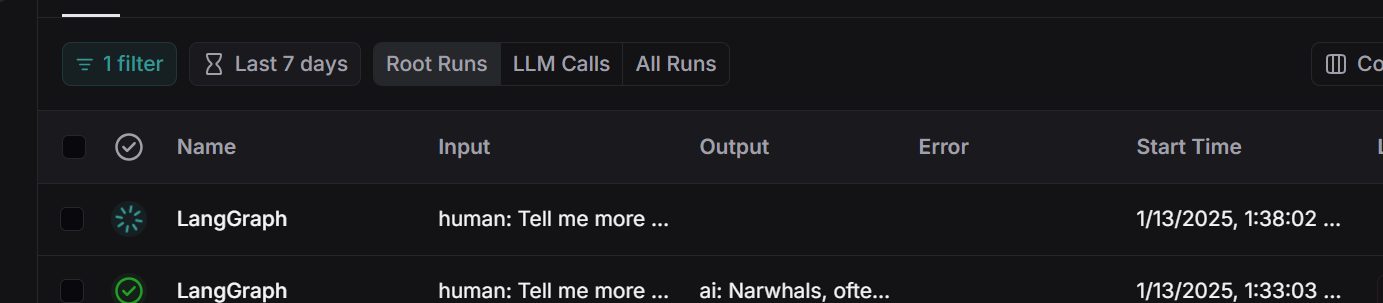

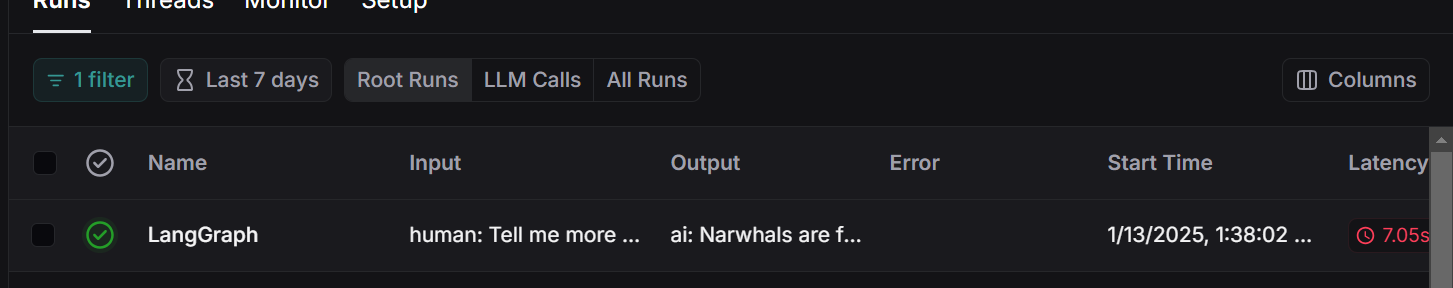

In [22]:
# langsmith does not show last message 

Trim messages

Another approach is to trim messages, based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the trim_messages below.

# this is extremely important for saving tokens as it restricted hstory to a speciic  number of tokens 

# While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

In [23]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}


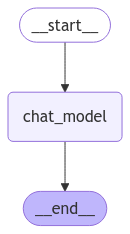

In [24]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [26]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [27]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [28]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  HumanMessage(content='Also , can you let me now  what is the best oceonagraph book to study about mammals?', additional_kwargs={}, response_metadata={}, name='Lance', id='5'),
  HumanMessage(content='Also , What is the capital of India?', additional_kwargs={}, response_metadata={}, name='Lance', id='6'),
  HumanMessage(content='Also , What is the capital of bangladesh?', additional_kwargs={}, response_metadata={}, name='Lance', id='7'),
  AIMessage(content='The capital of Bangladesh is Dhaka.', addi

In [29]:
##Now see how it comes up in langsmith

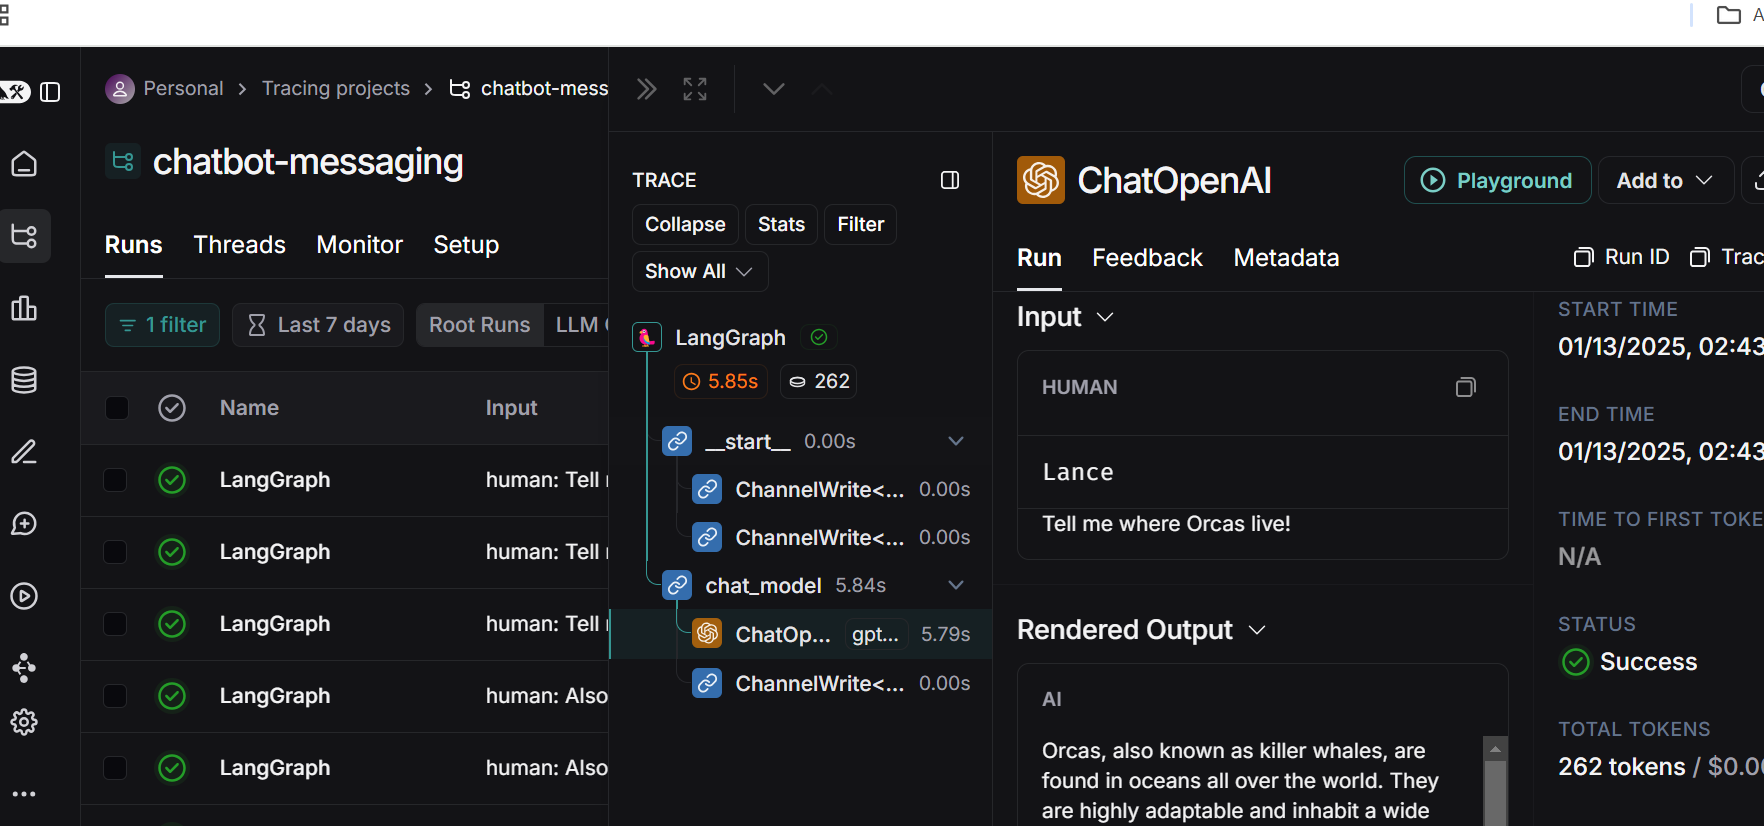

In [30]:
# next trim the message usimg max tokens =2000

In [31]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=2000,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 HumanMessage(content='Also , can you let me now  what is the best oceonagraph book to study about mammals?', additional_kwargs={}, response_metadata={}, name='Lance', id='5'),
 HumanMessage(content='Also , What is the capital of India?', additional_kwargs={}, response_metadata={}, name='Lance', id='6'),
 HumanMessage(content='Also , What is the capital of bangladesh?', additional_kwargs={}, response_metadata={}, name='Lance', id='7'),
 AIMessage(content='The capital of Bangladesh is Dhaka.', additional_kwargs={'refu

In [32]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim_2 = graph.invoke({'messages': messages})

In [33]:
messages_out_trim_2

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  HumanMessage(content='Also , can you let me now  what is the best oceonagraph book to study about mammals?', additional_kwargs={}, response_metadata={}, name='Lance', id='5'),
  HumanMessage(content='Also , What is the capital of India?', additional_kwargs={}, response_metadata={}, name='Lance', id='6'),
  HumanMessage(content='Also , What is the capital of bangladesh?', additional_kwargs={}, response_metadata={}, name='Lance', id='7'),
  AIMessage(content='The capital of Bangladesh is Dhaka.', addi

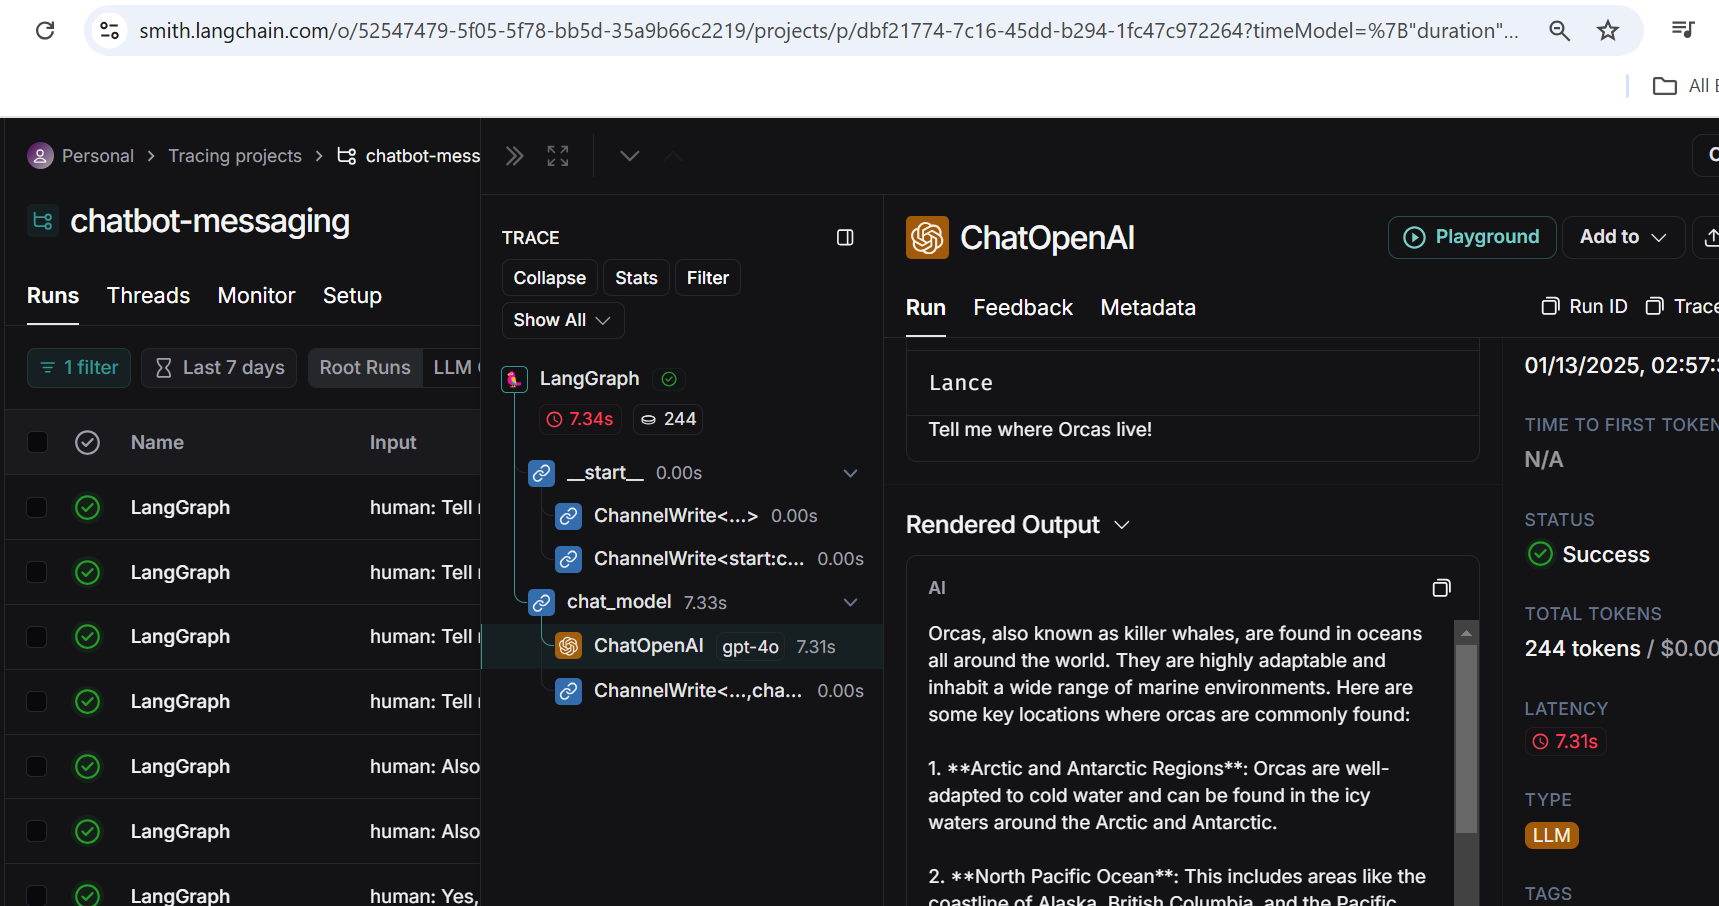